# Preamble

In [1]:
%matplotlib inline
# import numpy
import numpy as np
# import plotting libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.animation
from mpl_toolkits import mplot3d
# import pandas for reading values
import pandas as pd
# import a solver for equation solving
import scipy.optimize
# import schematics drawer
import SchemDraw as schem
import SchemDraw.elements as e

# Study case: shape

The pile that will be study in this project is based on a trapezoidal prism as shown in the figure below:

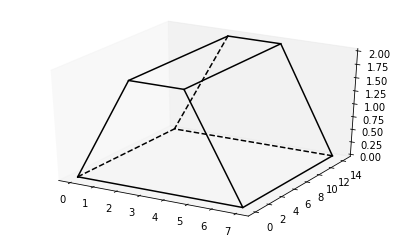

In [2]:
# sample trapezoidal prism values
alpha = 40 # angle between base and lateral side inside the volume
b = 7 # base
H = 2 # height
l = 100 #length
b2dif = H*np.tan(np.deg2rad(90-alpha))

# plot a sample pile
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.grid(False)
ax.plot([b2dif,b-b2dif,b],[l/b,l/b,l/b],[H,H,0],'k')
ax.plot([b,0,b2dif],[l/b,l/b,l/b],[0,0,H],'k--')
ax.plot([0,b2dif,b-b2dif,b,0],[0,0,0,0,0],[0,H,H,0,0],'k')
ax.plot([0,0],[0,l/b],[0,0],'k--')
ax.plot([b2dif,b2dif],[0,l/b],[H,H],'k')
ax.plot([b-b2dif,b-b2dif],[0,l/b],[H,H],'k')
ax.plot([b,b],[0,l/b],[0,0],'k')

The shape is described by just four parameters:
* Angle of the slope ($\alpha$)
* Width of the base ($b$)
* Height of the trapezoid ($H$)
* Length of the base ($l$)

However, if the <b> volume is to have a fixed value </b>, the number of variables of the prism is reduced by one (obtaining $l$ as a function of $\alpha, b, h$ and the fixed volume of the snow pile)

In [3]:
# function to compute the volume of the pile
def vol(alpha, b, H, l):
    # get the upper side of the trapezoid
    b2 = b - 2*H*np.tan(np.deg2rad(90-alpha))
    # get the trapezoidal area
    frontArea = H*(b+b2)/2
    # get the volume with the length
    volume = frontArea*l
    return volume

In [4]:
# fixed volume of the pile
fixedVol = 10000

In [5]:
# lambda function to subtract a volume given by (alpha, b, H, l) 
# to the fixed volume for the optimization process
fVol = lambda l, b, H, alpha, fixedVol : vol(alpha, b, H, l)-fixedVol

In [6]:
# get the length of a pile given by some (alpha, b, H) and volume
Lopt = scipy.optimize.fsolve(fVol, 1e3, args=(b, H, alpha, fixedVol))

In [7]:
# check whether the length returns the desired fixed volume 
# (using round as accuracy is affected by machine precission)
np.round(vol(alpha, b, H, Lopt),10) == np.round(fixedVol, 10)

array([ True])

# Study case: heat transfer

Before proceeding on how the different values have been obtained, it is worth showing which variables will be listed:
* $\alpha \in [20^o,60^o]$
* $b \in [0.2\ m , 10\ m] $
* $h \in [0.5\ m, 5\ m]$
* $t_{ins} \in [0.001\ m, 0.1\ m]$
* $k_{ins} \in [0.05\ W/(m\cdot K), 0.2\ W/(m\cdot K)]$
* $\varepsilon_{ins} \in [0,1]$
* $A_{ins} \in [0,1]$

Those are the variables of which the design can be changed: vary the shape of the snow pile ($\alpha, h, b$), having as said before a fixed volume for a fair comparison, and the type of insulator with its characteristics (thickness $t$, thermal conductivity $k$, emissivity $\varepsilon$ and absorptivity $A$ of the material). For absorptivity, letter $A$ will be used instead of $\alpha$ to avoid confusion with the snow pile $\alpha$.

The thermal diagram is shown below:

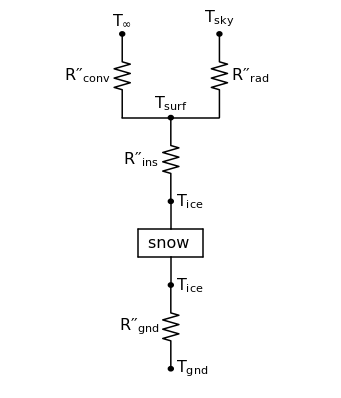

In [8]:
d = schem.Drawing()
# ghost resistance to add some white space below
d.add(e.RES, d = 'right', color = "white")
# back to the heat transfer circuit
d.add(e.DOT, toplabel = r"$T_\infty$")
d.add(e.RES, d = 'down', label = "$R\prime\prime_{conv}$")
d.add(e.LINE, d= 'right', l = 1.5)
d.push()
d.add(e.LINE, d= 'right', l = 1.5)
d.add(e.RES, d = 'up', botlabel = "$R\prime\prime_{rad}$")
d.add(e.DOT, toplabel = r"$T_{sky}$")
# ghost resistance to add some white space below
d.add(e.RES, d = 'right', color = "white")
# back to the heat transfer circuit
d.pop()
d.add(e.DOT, toplabel = r"$T_{surf}$")
d.add(e.RES, d = 'down', label = "$R\prime\prime_{ins}$")
d.add(e.DOT, rgtlabel = r"$T_{ice}$")
d.add(e.LINE, d= 'down', l = 1)
d.push()
d.add(e.LINE, d= 'left', l = 1)
d.add(e.LINE, d= 'down', l = 1)
d.add(e.LINE, d= 'right', l = 1)
d.pop()
d.add(e.LINE, d= 'right', l = 1)
d.add(e.LINE, d= 'down', l = 1, label = r"snow  ")
d.add(e.LINE, d= 'left', l = 1)
d.add(e.LINE, d= 'down', l = 1)
d.add(e.DOT, rgtlabel = r"$T_{ice}$")
d.add(e.RES, d = 'down', label = "$R\prime\prime_{gnd}$")
d.add(e.DOT, rgtlabel = r"$T_{gnd}$")
d.draw()

## Conductive heat transfer

The heat transfer from convection comes from:
$$
q''_{conv}=h\left(T_{\infty}−T_{surf}\right)
$$

In [9]:
# data from
# https://espanol.wunderground.com/history/airport/KMVL/2017/6/11/CustomHistory.html?dayend=17&monthend=2&yearend=2018&req_city=&req_state=&req_statename=&reqdb.zip=&reqdb.magic=&reqdb.wmo=

# range of dates
# from 2017-06-11 to 2018-02-17

# header of the file
# Day 	Temp. (°C)          	Dew point (°C)      	Humidity (%)        	Sea Level Press. (hPa) 	Visibility (km)     	Wind (km/h) 	Precip. (mm) 	
# Day 	high 	avg 	low 	high 	avg 	low 	high 	avg 	low 	high 	avg 	low 	high 	avg 	low 	high 	avg 	high 	sum 	 

# get the values and remove the non valids
wD = np.genfromtxt('weatherData.txt', usecols=(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19), delimiter=' ')
# remove invalid values
wD[np.isnan(wD)] = 0

In [10]:
# compute the density of air transforming hPa to Pa and ºC to K
airRho = (wD[:,11]*1e2)/((wD[:,2]+273.15)*287)
# preallocate an array to get the Reynolds
Re = np.zeros((len(wD[:,2])))
# take an average of the distances
dist = (l+b)/2

# air variables obtained from 
# Fundamentals of Heat and Mass Transfer
# ISBN 13 978-0470-50197-9
# air dynamic viscosity in N·s/m^2
airMu = np.interp(wD[:,2]+273.15, 
                  [200,250,300], [132.5e-7,159.6e-7,184.6e-7])
# air kinematic viscosity in m^2/s
airNu = np.interp(wD[:,2]+273.15, 
                  [200,250,300], [7.59e-6,11.4e-6,15.89e-6])
# air dynamic viscosity in m^2/s
airAlpha = np.interp(wD[:,2]+273.15, 
                     [200,250,300], [10.3e-6,15.9e-6,26.3e-6])
# air dynamic viscosity in W/(m·K)
airK = np.interp(wD[:,2]+273.15, 
                 [200,250,300], [18.1e-3,22.3e-3,26.3e-3])

# Reynolds number calculation (wD is wind speed)
Re = airRho*wD[:,17]*dist/airMu
# compute Nusselt number
Nu = 0.0296*Re**(4./5.)*(airNu/airAlpha)**(1./3.)
# compute convective heat transfer coefficient
dailyH = Nu*airK/dist
# get the mean of the convective heat transfer coefficient
h = np.mean(dailyH)

In [11]:
# computation of the 'inf' temperature from ambient temperature
Tinf = (wD[:,2]+273.15).mean()

## Radiative heat transfer

The heat transfer from radiation comes from:
$$
q''_{rad}=A_{ins}G_{solar}+\varepsilon_{ins}\sigma\left(T^4_{sky}−T^4_{surf}\right)
$$

In [12]:
# load the NOAA values for sun incidende
NOAAradiation = np.genfromtxt('global_radiation.txt', delimiter='', skip_header = 14, unpack=True, dtype=float)

# get the coordinates of the station
mask = np.where(np.logical_and(NOAAradiation[0,:] == 44, NOAAradiation[1,:] == -73))

solar_radiation = np.zeros(12)
for i in range(12):
    solar_radiation[i] = NOAAradiation[i+2,mask]
    
# values are in kWh/(m^2 day) so let's get it W/m^2 and get a mean representative value
Gsolar = (solar_radiation*1e3/24).mean()

In [13]:
# Data taken from
# https://www.currentresults.com/Weather/Vermont/sunshine-by-month.php
# using data from June to February as ground data available (later on that)
clouds = 1-np.array([0.56,0.59,0.64,0.60,0.54,0.47,0.31,0.33,0.41,0.48])

# get the average monthly temperature from input data, using indexing
days = np.array([20,31,31,30,31,30,31,31,19])
# prealocate space for monthly averages for all variables
m_wD = np.zeros((len(clouds),np.shape(wD)[1]))
# compute each mean
for i in range(len(days)):
    m_wD[i,:] = np.mean(wD[np.sum(days[:i]):np.sum(days[:i+1]),:], axis=0)
    
# compute emmisitivity of the clouds
e_cloud = (1-.84*clouds)*(0.527 + 0.161*np.exp(8.45*(1-(273/(m_wD[:,2]+273.15))))) + 0.84*clouds
# compute sky temperature
T_sky = ((9.365574e-6)*(1-clouds)*(m_wD[:,2]+273.15)**6 + e_cloud*clouds*(m_wD[:,2]+273.15)**4)**.25
# the average sky temperature can be taken as the mean value
Tsky = T_sky.mean()

In [14]:
# Stephan Boltzmann constant in SI units
sigma = 5.67036713e-8

## Conductive heat transfer: upper surfaces

The heat transfer from conduction comes from:
$$
q''_{ins}=k_{ins}\dfrac{\left(T_{surf}−T_{ice}\right)}{t_{ins}}
$$

The value of $k_{ins}$ an $t_{ins}$ are some of the variables of the case. Moreover, the <b> temperature of the ice is fixed </b> to $T_{ice}=-10^oC$

In [15]:
Tice = -10+273.15
Kins = 0.1
Tins = 0.05

Define also the other variables for a sample run

In [16]:
Ains = 0.04
Eins = 0.04

## Upper surface temperature

From the conductive, convective and radiative heat transfers, the temperature of the upper surface can be computed with a solver as:
$$
\left.
\begin{matrix}
q''_{conv}=h\left(T_{\infty}−T_{surf}\right) \\
q''_{rad}=A_{ins}G_{solar}+\varepsilon_{ins}\sigma\left(T^4_{sky}−T^4_{surf}\right) \\
q''_{ins}=k_{ins}\dfrac{\left(T_{surf}−T_{ice}\right)}{t_{ins}}
\end{matrix} 
\right\} \xrightarrow{\quad q''_{conv}+q''_{rad}=q''_{ins} \quad} h\left(T_{\infty}−T_{surf}\right)+A_{ins}G_{solar}+\varepsilon_{ins}\sigma\left(T^4_{sky}−T^4_{surf}\right) = k_{ins}\dfrac{\left(T_{surf}−T_{ice}\right)}{t_{ins}}
$$

Solving numerically for $T_{surf}$ will provide the surface temperature

In [17]:
# first define the function that should be zero 
def Tsurf_fun(Tsurf, *data):
    h, Tinf, Ains, Gsolar, Eins, sigma, Tsky, Kins, Tice, Tins = data
    qconv = h*(Tinf-Tsurf)
    qrad = Ains*Gsolar + Eins*sigma*(Tsky**4-Tsurf**4)
    qins = Kins*(Tsurf-Tice)/Tins
    return qconv + qrad - qins

# solve the function
Tsurf = scipy.optimize.fsolve(Tsurf_fun, Tice, 
                              args=(h, Tinf, Ains, Gsolar, Eins, sigma, Tsky, Kins, Tice, Tins))

# check if solution is correct (using round as accuracy is affected by machine precission)
np.round(h*(Tinf-Tsurf) + Ains*Gsolar + Eins*sigma*(Tsky**4-Tsurf**4),10) == np.round(Kins*(Tsurf-Tice)/Tins,10)

array([ True])

## Conductive heat transfer: soil surface

In [18]:
pond_543 = pd.read_csv("groundData1.csv", squeeze=True, parse_dates=[0], index_col=[0],
                      header = 1, names = ["p50cm", "p1m"])
pond_544 = pd.read_csv("groundData2.csv", squeeze=True, parse_dates=[0], index_col=[0],
                      header = 1, names = ["p5cm", "p20cm"])

In [19]:
# remove NaN and NaT within the columns
pond_543 = pond_543.dropna()
pond_544 = pond_544.dropna()

In [20]:
# remove times without any value within the temperature field
pond_543 = pond_543[pond_543.p50cm != ' ']
pond_544 = pond_544[pond_544.p5cm != ' ']

In [21]:
# convert numeric values to float 
pond_543 = pond_543.astype(float)
pond_544 = pond_544.astype(float)

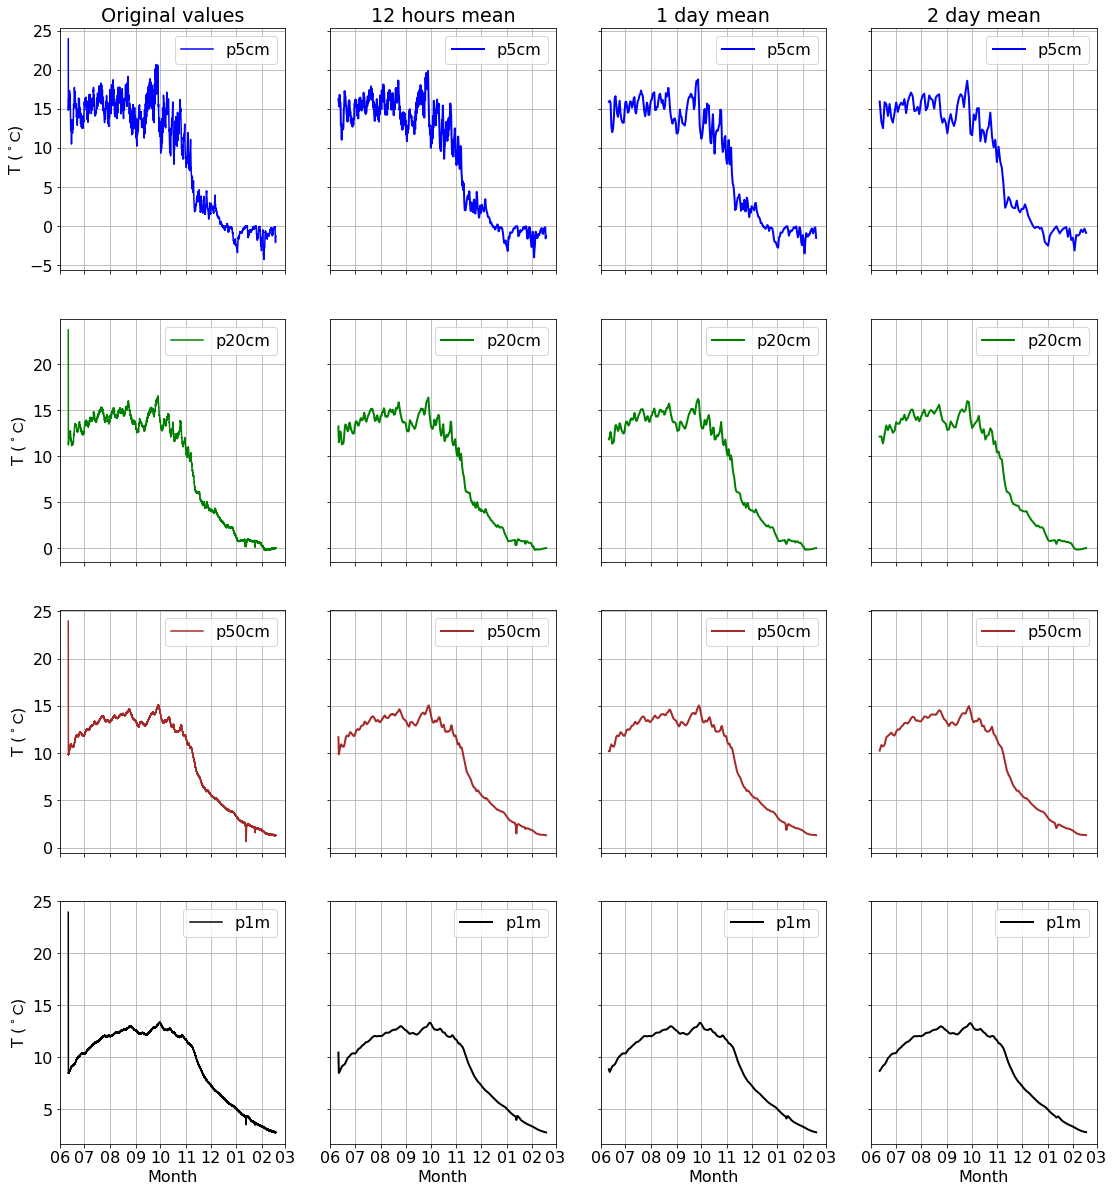

In [22]:
fig, ax = plt.subplots(4,4, sharex=True, sharey='row', figsize=(16,20))
# plot original values
ax[0][0].plot(pond_544.p5cm,'b')
ax[1][0].plot(pond_544.p20cm,'g')
ax[2][0].plot(pond_543.p50cm,'brown')
ax[3][0].plot(pond_543.p1m,'k')
# plot 12 hour means
average = '12H'
ax[0][1].plot(pond_544.resample(average).mean().p5cm,'b', lw=2)
ax[1][1].plot(pond_544.resample(average).mean().p20cm,'g', lw=2)
ax[2][1].plot(pond_543.resample(average).mean().p50cm,'brown', lw=2)
ax[3][1].plot(pond_543.resample(average).mean().p1m,'k', lw=2)
# plot daily means
average = '1D'
ax[0][2].plot(pond_544.resample(average).mean().p5cm, 'b', lw=2)
ax[1][2].plot(pond_544.resample(average).mean().p20cm, 'g', lw=2)
ax[2][2].plot(pond_543.resample(average).mean().p50cm, 'brown', lw=2)
ax[3][2].plot(pond_543.resample(average).mean().p1m, 'k', lw=2)
# plot 2 day means
average = '2D'
ax[0][3].plot(pond_544.resample(average).mean().p5cm, 'b', lw=2)
ax[1][3].plot(pond_544.resample(average).mean().p20cm, 'g', lw=2)
ax[2][3].plot(pond_543.resample(average).mean().p50cm, 'brown', lw=2)
ax[3][3].plot(pond_543.resample(average).mean().p1m, 'k', lw=2)
# plot customization
[ax[-1][i].set_xlim(pd.Timestamp('2017-06-01'),pd.Timestamp('2018-03-01')) for i in range(len(ax))]
[ax[-1][i].xaxis.set_major_locator(mdates.MonthLocator()) for i in range(len(ax))]
[ax[-1][i].xaxis.set_major_formatter(mdates.DateFormatter("%m")) for i in range(len(ax))]
[ax[-1][i].set_xlabel(r"Month") for i in range(len(ax))]
[ax[i][0].set_ylabel(r"$T$ ($^\circ\mathrm{C}$)") for i in range(len(ax))]
[[ax[i][j].legend(loc='upper right', fancybox=True) for i in range(len(ax))] for j in range(len(ax))]
[[ax[i][j].grid(True) for i in range(len(ax))] for j in range(len(ax))];
[ax[0][i].set_title('%s' %['Original values','12 hours mean','1 day mean','2 day mean'][i]) 
 for i in range(len(ax))];

Ideally the snow will vary the temperature of the soil close to the pile, having that the temperature further deep <b>will not be</b> modified. Thus the temperature of the probe located at $1\ m$ deep will be used as $T_{ground}$.

In [23]:
average = '1D'
temp = pd.DataFrame()
temp['_5cm'] = pond_544.resample(average).mean().p5cm
temp['_20cm'] = pond_544.resample(average).mean().p20cm
temp['_50cm'] = pond_543.resample(average).mean().p50cm
temp['_100cm'] = pond_543.resample(average).mean().p1m

Assuming that the conductivity coefficient of the soil is constant for all layers within $0.05 m$ and $1.0 m$, the next step is to compute and plot the different heat transfer values to get drain of heat.

In [24]:
q = pd.DataFrame()
# assuming constant thermal conductivity
# the type of soil under the sky station is cambrian (see link), which is first Paleozoic
# https://pasarelapr.com/images/types-of-maps-for-kids/types-of-maps-for-kids-6.jpgk_soil = 1 
# from that, the thermal coefficient is (see link)
# https://www.researchgate.net/profile/Yinhui_Zuo/publication/308922712/figure/tbl1/AS:614124430037000@1523430082926/Rock-heat-production-rate-and-thermal-conductivity-of-each-tectonic-layer-in-the-Bohai_W640.jpg
k_soil = 3.0
# compute different heat transfers
q['_20_5_cm'] = -k_soil*(temp._20cm - temp._5cm)/0.15
q['_50_5_cm'] = -k_soil*(temp._50cm - temp._5cm)/0.45
q['_100_5_cm'] = -k_soil*(temp._100cm - temp._5cm)/0.95
q['_50_20_cm'] = -k_soil*(temp._50cm - temp._20cm)/0.30
q['_100_20_cm'] = -k_soil*(temp._100cm - temp._20cm)/0.80
q['_100_50_cm'] = -k_soil*(temp._100cm - temp._50cm)/0.50
# ave_Pond_543['q_20_50'] = -k_soil*(ave_Pond_543.p50cm - ave_Pond_544.p20cm)/0.3
# ave_Pond_543['q_5_20'] = -k_soil*(ave_Pond_544.p20cm - ave_Pond_544.p5cm)/0.15

Text(0.5, 1.0, 'Heat transfer')

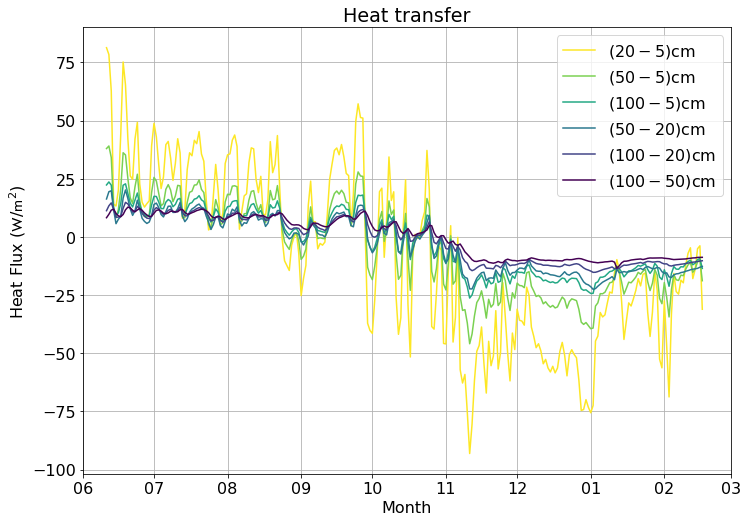

In [25]:
fig, ax = plt.subplots(1, figsize=(10,8))
# plot the heat transfer values
ax.plot(q._20_5_cm,c=plt.cm.viridis(5/5),label=r'$(20-5) cm$')
ax.plot(q._50_5_cm,c=plt.cm.viridis(4/5),label=r'$(50-5) cm$')
ax.plot(q._100_5_cm,c=plt.cm.viridis(3/5),label=r'$(100-5) cm$')
ax.plot(q._50_20_cm,c=plt.cm.viridis(2/5),label=r'$(50-20) cm$')
ax.plot(q._100_20_cm,c=plt.cm.viridis(1/5),label=r'$(100-20) cm$')
ax.plot(q._100_50_cm,c=plt.cm.viridis(0/5),label=r'$(100-50) cm$')
# plot customization
ax.set_xlim(pd.Timestamp('2017-06-01'),pd.Timestamp('2018-03-01')) 
ax.xaxis.set_major_locator(mdates.MonthLocator()) 
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m")) 
ax.set_xlabel(r"Month") 
plt.ylabel(r"Heat Flux ($\mathrm{W}/\mathrm{m}^2)$")
ax.legend(loc='upper right', fancybox=True)
ax.grid(True)
ax.set_title('Heat transfer')

In the above figure can be seen that the use of more stable temperature profiles result in the most stable heat flux profiles, having that the $100-50$ profile gives a very smooth curve, having that also $100-5$ provides a very intersting approach (given that it uses the maximum length available). What is more interesting and can be seen more evidently in the next graph is the fact that heat flux sign gets inverted after November has started. This could have been also observed in the temperature figures, where the $100cm$ probe doesn't go much below 5ºC while the 'surface' temperature ($5cm$ probe) goes even below 0ºC.

Text(0.5, 1.0, 'Heat transfer')

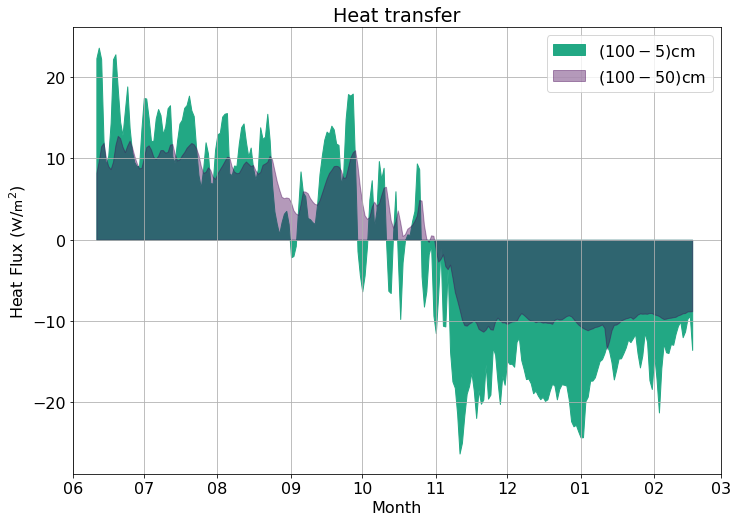

In [26]:
fig, ax = plt.subplots(1, figsize=(10,8))
# plot the heat transfer values
ax.fill_between(temp.index,q._100_5_cm,color=plt.cm.viridis(3/5),label=r'$(100-5) cm$')
ax.fill_between(temp.index,q._100_50_cm,color=plt.cm.viridis(0/5),alpha=0.4,label=r'$(100-50) cm$')
# plot customization
ax.set_xlim(pd.Timestamp('2017-06-01'),pd.Timestamp('2018-03-01')) 
ax.xaxis.set_major_locator(mdates.MonthLocator()) 
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m")) 
ax.set_xlabel(r"Month") 
plt.ylabel(r"Heat Flux ($\mathrm{W}/\mathrm{m}^2)$")
ax.legend(loc='upper right', fancybox=True)
ax.grid(True)
ax.set_title('Heat transfer')

The heat transfer per unit area will therefore be computed as:
$$
q''_{gnd}=k_{soil}\dfrac{\left(T_{gnd}−T_{ice}\right)}{d}
$$
where $d$ is the depth at which $T_{gnd}$ is referred. From what has been shown before, the most stable temperature profile is given by the probe at $-100\ cm$, using the mean as the ground temperature and its corresponding depth of $d=1\ m$.

In [27]:
Tgnd = pond_543.mean().p1m +273.15
d = 1

## Total heat loss

Once the heat per unit area has been computed, it should be computed the total loss of heat, separating from the 5 surfaces that are in contact with the air and the surface that is in contact with the soil.

In [28]:
# heat loss in the air surfaces
# the conductive heat through the insulation is the same as radiation+convective
# so it is the same whether one or the other is used
qins = Kins*(Tsurf-Tice)/Tins
# upper base width
b2 = b - 2*H*np.tan(np.deg2rad(90-alpha))
# lateral size
ls = H/np.cos(np.deg2rad(90-alpha))
# the air surface is 2*(trapezoidal front) + (upper rectangle) + 2*(side rectangles)
air_surf = 2*(H*(b+b2)/2) + (b2*l) + 2*(ls*l)
# the air surface heat is
qair = qins*air_surf

In [29]:
# heat loss in the soil surfaces
# the heat that goes from the soil is
qgnd = k_soil*(Tgnd-Tice)/d
# the soil surface is simply the rectangle given by
soil_surf = b*l
# the soil surface heat is
qsoil = qgnd*soil_surf

Once that everything has been set up, the basic information is transferred to the <tt> fitness.py</tt> script. This two values of heat will be used as fitness values for the individuals in the optimization process.